LSTM on past power data to predict power 1, 2 and 3 hours ahead

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy.stats import norm

# Import pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
x_train = pd.read_csv('windforecasts_wf1.csv', index_col='date')
y_train = pd.read_csv('train.csv')
# just consider the wind farm 1

In [4]:
# Brainstorm
# One metric for 24 hs and other for 48 hs ?
# 0) Check which wind farm to take before working on wf 1
# 0) calculating the MAE for AR-3  -> Baseline RMSE (Confidence interval?)
# 1) Making a prediction based on wp1 using LSTM
# 2) Metric for evaluating the model

In [5]:
y_train['date'] = pd.to_datetime(y_train.date, format= '%Y%m%d%H')
y_train.index = y_train['date'] 
y_train.drop('date', inplace = True, axis = 1)

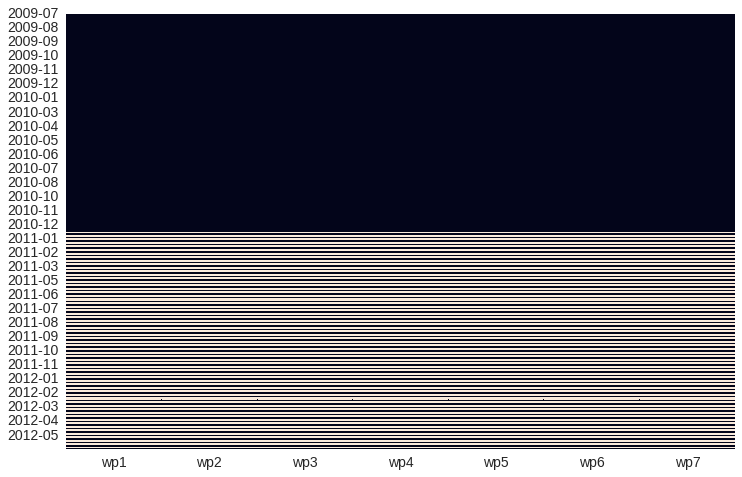

In [126]:
# Plot heatmap of missing data
ALL_TIME = pd.DataFrame(index=pd.date_range(y_train.index[0],y_train.index[-1], freq='H')) 
plt.figure(figsize = (12,8))
# 
plot_data = y_train.join(ALL_TIME, how = 'outer').isna()
plot_data.index = plot_data.index.strftime('%Y-%m')

sns.heatmap(plot_data, cbar = False)  #['2011-06-01':'2011-06-04']

In [112]:
pd.date_range(y_train.index[0],y_train.index[-1], freq='H').strftime('%Y-%m-%d')

Index(['2009-07-01', '2009-07-01', '2009-07-01', '2009-07-01', '2009-07-01',
       '2009-07-01', '2009-07-01', '2009-07-01', '2009-07-01', '2009-07-01',
       ...
       '2012-06-26', '2012-06-26', '2012-06-26', '2012-06-26', '2012-06-26',
       '2012-06-26', '2012-06-26', '2012-06-26', '2012-06-26', '2012-06-26'],
      dtype='object', length=26197)

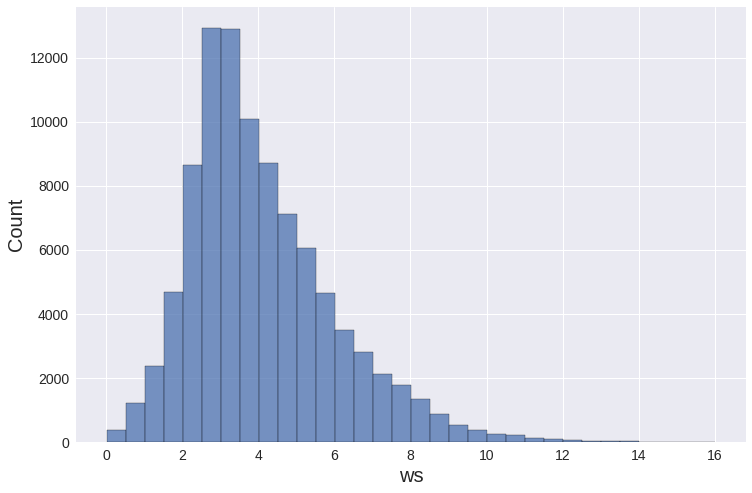

In [132]:
sns.histplot(x_train.ws, binwidth = 0.5, norm )

In [133]:
help(sns.histplot)

Help on function histplot in module seaborn.distributions:

histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
    Plot univariate or bivariate histograms to show distributions of datasets.
    
    A histogram is a classic visualization tool that represents the distribution
    of one or more variables by counting the number of observations that fall within
    disrete bins.
    
    This function can normalize the statistic computed within each bin to estimate
    frequency, density or probability mass, and it can add a smooth curve obtained
    using a kernel density estimate,

In [7]:
# Select forecast data set
x_train_update = x_train[x_train.hors<=12]
x_train_update.index = pd.to_datetime(x_train_update.index, format= '%Y%m%d%H')
x_train_update = x_train_update[:'2010-12-31 12']
x_train_update['time'] = x_train_update.index + pd.to_timedelta(x_train_update.hors,"H")

maxi=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.max()
mini=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.min()
x_train_update.ws=(x_train_update.ws-mini)/(maxi-mini)

# One hot encode the wind directions
wd_onehot = []

for i in range(len(x_train_update)):
  onehot = 12*[None]
  sector = np.floor(x_train_update.wd[i]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd_onehot.append(onehot)
  
  
x_train_sectors = pd.DataFrame(np.concatenate((np.reshape(x_train_update.ws.values,(len(x_train_update),1)),
                                              wd_onehot,
                                              np.cos(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.sin(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.cos(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365),
                                              np.sin(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365)),
                                            axis = 1),
            columns = 'ws s1 s2 s3 s4 s5 s6 s7 s8 s9 s10 s11 s12 time_day_cos time_day_sin time_year_cos time_year_sin'.split())
x_train_sectors.drop('s12',axis=1, inplace=True)

In [8]:
# Use only the power time series when continuous
complete_ts = y_train[:'2011-01-01 00'] # all the data without any gaps
input_generator = np.transpose(np.array([complete_ts.wp1]))
length = 36 # length of the time series, PARAMETER TO TUNE

In [9]:
# define validation and training set

batch_size = 128
# input_generator = np.transpose(np.array([y_train.wp1]))

# Note: TimeseriesGenerator end_index is including that index, not excluding it as it is the case in general in Python

training_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = 0 , end_index = int(len(complete_ts)*0.8)) # 80 percent
validation_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = int(len(complete_ts)*0.8)+1, end_index = len(complete_ts)-1)

In [10]:
print(f'The lenght of the validation set: {len(validation_set)}')
print(f'The lenght of the training set: {len(training_set)}')

The lenght of the validation set: 21
The lenght of the training set: 83


**Creation of LSTM architecture**

In [11]:
class FFNN_LSTM(nn.Module):
    def __init__(self):
        super(FFNN_LSTM, self).__init__()
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # batch_first = False >>> input prov (seq, batch, feature)

        self.lstm = nn.LSTM(input_size = 1, 
                  hidden_size = 32,#1028,
                     num_layers = 1,
                         batch_first = False)
        

        self.inputLay = nn.Linear(in_features = 16,
                               out_features = 32,#512,
                               bias = True)
        
        self.hidden_layer = nn.Linear(in_features = 32,#512,
                                      out_features = 32,#,512,
                                      bias = True)
        
        self.combined = nn.Linear(in_features= 32+32,#1028+512, 
                        out_features= 32,#512,
                        bias = True) # should be false ?

        self.output_lay = nn.Linear(in_features= 32,#512, 
                        out_features= 1,
                        bias = True) # should be false ?

                 
    def forward(self, pow_seq, for_feat):
        #print(np.shape(x))
        x = torch.permute(pow_seq, (1,0,2) )  # permute batch with sequence 
        #print(np.shape(x))
        x, (h, c) = self.lstm(x)

        x = x[-1] # takes the last hidden state of LSTM
        #print(x)
        #print(np.shape(x))
        # Dense layer
        y = self.inputLay(for_feat)
        y = F.elu(y) # F = nn.Functional
        y = self.hidden_layer(y)
        y = F.elu(y)
        #print(y)
        #print(np.shape(y))
        z = torch.cat( (x,y), dim = 1 )
        #print(np.shape(z))
        z = self.combined(z)
        z = F.elu(z)
        z = self.output_lay(z)

        return z
  
net = FFNN_LSTM()
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

print(net)


##converting network to cuda-enabled
FFNN_LSTM(
  (lstm): LSTM(1, 32)
  (inputLay): Linear(in_features=16, out_features=32, bias=True)
  (hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (combined): Linear(in_features=64, out_features=32, bias=True)
  (output_lay): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
myObj = FFNN_LSTM()
pow_seq = torch.Tensor(np.array([[[0.3],[0.4],[0.6]],[[0.3],[0.4],[0.6]]]))
for_feat = torch.Tensor([np.ones(16), np.ones(16)])
myObj(pow_seq , for_feat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[0.1786],
        [0.1786]], grad_fn=<AddmmBackward0>)

# define early stopping class 

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

**Training of the LSTM**

In [157]:
ExelResults = pd.read_excel('Comparison_models_intraday.xlsx', index_col= 0, header = None , names = 'Model 1hr 2hr 3hr 4hr 5hr 6hr'.split() )
ExelResults 

,1hr,2hr,3hr,4hr,5hr,6hr
Model,,,,,,
Persistent,0.072,0.114,0.143,0.167,0.188,0.205
AR(3),0.069,0.110,0.137,0.158,0.176,0.190
LSTM AR(24),0.073,0.119,0.153,0.181,0.204,0.221
LSTM AR(36) + FFNN*,0.066,0.099,0.118,0.130,0.139,0.144
FFNN,0.168,0.168,0.168,0.168,0.168,0.168


In [158]:
#matplotlib notebook
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rcParams['text.usetex'] = False
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE , frameon = True, fancybox = True, loc = 'lower left')    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [56]:
ExelResults.T.index.values

array(['1hr', '2hr', '3hr', '4hr', '5hr', '6hr'], dtype=object)

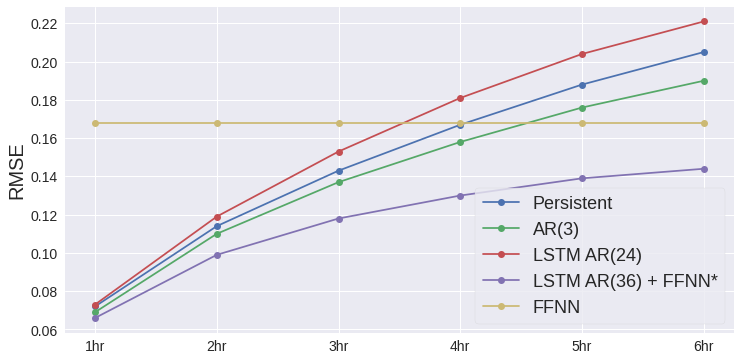

In [159]:
fig, ax = plt.subplots(figsize = (12,6))
ExelResults.T.plot(style='o-',ax=ax)
ax.set_ylabel('RMSE')
ax.legend(loc = 'lower right')

In [30]:
## 
model = net
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [31]:
# Train loop 
criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(),lr=5e-6) # , momentum=0.9

training_loss, validation_loss = [], []  # store loss for each epoch
num_epochs = 15000 # should be tuned

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=1000, verbose=True)

for i in range(num_epochs):
  # Track loss
  epoch_training_loss = 0
  epoch_validation_loss = 0
  net.eval() # EVALUATION mode -> dont use regularization methods
    
  # For each sentence in validation set
  for j,(inputs, targets) in enumerate(validation_set):

    # Convert input to tensor
    inputs_pow = torch.Tensor(inputs)

    # ADD (length-1) hours and not length because the first forecast (index 0) is already for the next hour after the first observation.
    # The forecast in index (length-1) is then after the length first observations.
    # A -1 was added because the training set of forecast has one less value.

    inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1+int(len(complete_ts)*0.8)+1-1):((j+1)*batch_size+length-1+int(len(complete_ts)*0.8)+1-1)].values)        
    # print('Inside training loop')
    # print(f'shape of input {np.shape(inputs)}')

    if len(inputs_pow) != batch_size:
      inputs_pred = inputs_pred[:len(inputs_pow)]

    # Convert target to tensor
    targets = torch.Tensor(targets)
    #print(targets)
    # print(f'shape of targets {np.shape(targets)}')

    #Convert targets and inputs to cuda
    if torch.cuda.is_available():
        inputs_pow = Variable(inputs_pow.cuda())
        inputs_pred = Variable(inputs_pred.cuda())
        targets = Variable(targets.cuda())

    # Evaluate the model
    outputs = net(inputs_pow,inputs_pred) 

    # print(f'shape of outputs {np.shape(outputs)}')
    #print(outputs)
    # Compute loss


    loss =  criterion(outputs,targets) 

    if torch.cuda.is_available():
      epoch_validation_loss += loss.cpu().detach().numpy()
    else:
      epoch_validation_loss += loss.detach().numpy() # suma el loss de cada batch, luego se reinicia para proxima epoch


  net.train()

  for j,(inputs, targets) in enumerate(training_set):

    # Convert input to tensor
    inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1):((j+1)*batch_size+length-1)].values)
    inputs_pow = torch.Tensor(inputs)
    # print('Inside training loop')
    # print(f'shape of input {np.shape(inputs)}')

    # Convert target to tensor
    targets = torch.Tensor(targets)
    #print(targets)
    # print(f'shape of targets {np.shape(targets)}')

    if len(inputs_pow) != batch_size:
      inputs_pred = inputs_pred[:len(inputs_pow)]

    #Convert targets and inputs to cuda
    if torch.cuda.is_available():
        inputs_pow = Variable(inputs_pow.cuda())
        inputs_pred = Variable(inputs_pred.cuda())
        targets = Variable(targets.cuda())

    # Evaluate the model
    outputs = net(inputs_pow,inputs_pred)      
    # print(f'shape of outputs {np.shape(outputs)}')
    #print(outputs)
    # Compute loss
    loss =  criterion(outputs,targets)

    optimizer.zero_grad() # zero the gradients
    loss.backward()       # calculate gradients for current step
    optimizer.step()      # update the weights 

    if torch.cuda.is_available():
      epoch_training_loss += loss.cpu().detach().numpy()
    else:
      epoch_training_loss += loss.detach().numpy()

        

  # Save loss for plot
  avg_train_loss=np.sqrt(epoch_training_loss/(len(training_set)))
  avg_valid_loss=np.sqrt(epoch_validation_loss/(len(validation_set)))
  training_loss.append(avg_train_loss)
  validation_loss.append(avg_valid_loss)       
  print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

  # early_stopping needs the validation loss to check if it has decresed, 
  # and if it has, it will make a checkpoint of the current model
  early_stopping(avg_valid_loss, net)
    
  if early_stopping.early_stop:
    print("Early stopping")
    break


Epoch 0, training loss: 0.06510030007992818, validation loss: 0.06785981710095464
Validation loss decreased (inf --> 0.067860).  Saving model ...
Epoch 1, training loss: 0.06509899796560507, validation loss: 0.06785031507327223
Validation loss decreased (0.067860 --> 0.067850).  Saving model ...
Epoch 2, training loss: 0.06509905751211387, validation loss: 0.06785411212248721
EarlyStopping counter: 1 out of 1000
Epoch 3, training loss: 0.06509917609326245, validation loss: 0.06785719102821039
EarlyStopping counter: 2 out of 1000
Epoch 4, training loss: 0.06509927292943607, validation loss: 0.06785953896042189
EarlyStopping counter: 3 out of 1000
Epoch 5, training loss: 0.06509933068742119, validation loss: 0.06786102130825683
EarlyStopping counter: 4 out of 1000
Epoch 6, training loss: 0.06509934308682529, validation loss: 0.06786168622314398
EarlyStopping counter: 5 out of 1000
Epoch 7, training loss: 0.06509930399799212, validation loss: 0.06786168283302993
EarlyStopping counter: 6 o

KeyboardInterrupt: ignored

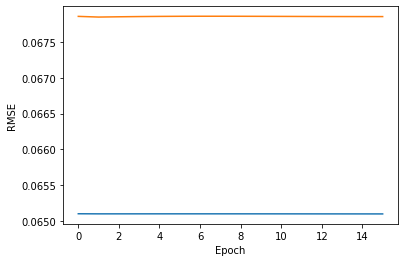

In [32]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, epoch, validation_loss)
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

**Evaluation of LSTM 1 to 6 hours ahead, on validation set**

In [61]:
# Define the validation set as one sequence
validation_power = input_generator[int(len(input_generator)*0.8)+1 : int(len(input_generator))-1]
validation_forecast_feats  = x_train_sectors.iloc[(length-1+int(len(complete_ts)*0.8)+1):len(x_train_sectors)]

In [62]:
# Define slices of 24h inputs and corresponding targets 1, 2 and 3 hours ahead
p_inputs = []
p_targets1h = []
p_targets2h = []
p_targets3h = []
p_targets4h = []
p_targets5h = []
p_targets6h = []

ff_inputs1h = []
ff_inputs2h = []
ff_inputs3h = []
ff_inputs4h = []
ff_inputs5h = []
ff_inputs6h = []

for i in range(len(validation_power)-(length+5)):
  ff_inputs1h.append(validation_forecast_feats.iloc[i].values)
  ff_inputs2h.append(validation_forecast_feats.iloc[i+1].values)
  ff_inputs3h.append(validation_forecast_feats.iloc[i+2].values)
  ff_inputs4h.append(validation_forecast_feats.iloc[i+3].values)
  ff_inputs5h.append(validation_forecast_feats.iloc[i+4].values)
  ff_inputs6h.append(validation_forecast_feats.iloc[i+5].values)


  p_inputs.append(validation_power[i:i+length])
  p_targets1h.append(validation_power[i+length])
  p_targets2h.append(validation_power[i+length+1])
  p_targets3h.append(validation_power[i+length+2])
  p_targets4h.append(validation_power[i+length+3])
  p_targets5h.append(validation_power[i+length+4])
  p_targets6h.append(validation_power[i+length+5])

In [ ]:
p_targets1h

In [ ]:
# x_train_sectors["time"]=x_train_update.time.values   # JUST FOR TESTING THE DATE IS APPROPIATE, dont delete

In [64]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []
pred_4h = []
err_4h = []
pred_5h = []
err_5h = []
pred_6h = []
err_6h = []

# Loop over the sequences of valid data
for seq in range(len(p_inputs)):

    # Define past value for the 1h forecast
    past = p_inputs[seq]
    ff = ff_inputs1h[seq]

    # Take output for the past sequence
    pred_1h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_1h.append(pred_1h[-1]-p_targets1h[seq][0])

    # Repeat with prediction 2 hours ahead actualizing the past values
    past = np.append(past,[[pred_1h[-1]]],0)
    ff = ff_inputs2h[seq]
    pred_2h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_2h.append(pred_2h[-1]-p_targets2h[seq][0])

    # Repeat with prediction 3 hours ahead
    past = np.append(past,[[pred_2h[-1]]],0)
    ff = ff_inputs3h[seq]
    pred_3h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_3h.append(pred_3h[-1]-p_targets3h[seq][0])

    # Repeat with prediction 4 hours ahead
    past = np.append(past,[[pred_3h[-1]]],0)
    ff = ff_inputs4h[seq]
    pred_4h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_4h.append(pred_4h[-1]-p_targets4h[seq][0])

    # Repeat with prediction 5 hours ahead
    past = np.append(past,[[pred_4h[-1]]],0)
    ff = ff_inputs5h[seq]
    pred_5h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_5h.append(pred_5h[-1]-p_targets5h[seq][0])

    # Repeat with prediction 6 hours ahead
    past = np.append(past,[[pred_5h[-1]]],0)
    ff = ff_inputs6h[seq]
    pred_6h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_6h.append(pred_6h[-1]-p_targets6h[seq][0])

    if seq % 100 == 0:
      print(f'step {seq+1}, RMSE 1h: {np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))}, RMSE 2h: {np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))}, RMSE 3h: {np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))}, RMSE 4h: {np.sqrt(stat.mean(err_4h[n]**2 for n in range(len(err_4h))))}, RMSE 5h: {np.sqrt(stat.mean(err_5h[n]**2 for n in range(len(err_5h))))}, RMSE 6h: {np.sqrt(stat.mean(err_6h[n]**2 for n in range(len(err_6h))))}')

step 1, RMSE 1h: 0.025845334291458133, RMSE 2h: 0.06004057145118713, RMSE 3h: 0.07456780648231509, RMSE 4h: 0.11811155533790585, RMSE 5h: 0.18804682326316835, RMSE 6h: 0.08586225724220276
step 101, RMSE 1h: 0.05675364649570075, RMSE 2h: 0.0858891511196467, RMSE 3h: 0.0969206590726063, RMSE 4h: 0.10093429878754698, RMSE 5h: 0.10454344733899375, RMSE 6h: 0.10793779310548589
step 201, RMSE 1h: 0.06353746186948825, RMSE 2h: 0.09181699126807356, RMSE 3h: 0.1041870596537795, RMSE 4h: 0.10754387998331241, RMSE 5h: 0.1105937565449692, RMSE 6h: 0.11413307049799716
step 301, RMSE 1h: 0.0660644844095004, RMSE 2h: 0.09642132994017273, RMSE 3h: 0.11029806506104921, RMSE 4h: 0.11578439649038709, RMSE 5h: 0.11905749794687934, RMSE 6h: 0.12268873879074786
step 401, RMSE 1h: 0.0644018768464358, RMSE 2h: 0.09542511525725568, RMSE 3h: 0.11100230757201238, RMSE 4h: 0.11835924076567499, RMSE 5h: 0.12296985947976725, RMSE 6h: 0.12685946574765072
step 501, RMSE 1h: 0.062399059196392465, RMSE 2h: 0.0924206680

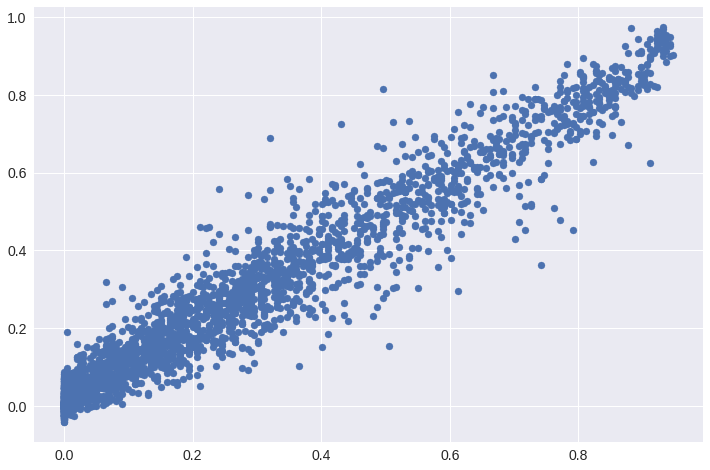

In [102]:
plt.scatter(p_targets1h , pred_1h)
from sklearn.metrics import r2_score
from scipy.stats import linregress
fit1h=linregress(np.reshape(np.array(p_targets1h), (len(p_targets1h,))), pred_1h)
fit6h=linregress(np.reshape(np.array(p_targets6h), (len(p_targets6h,))), pred_6h)

In [104]:
?linregress

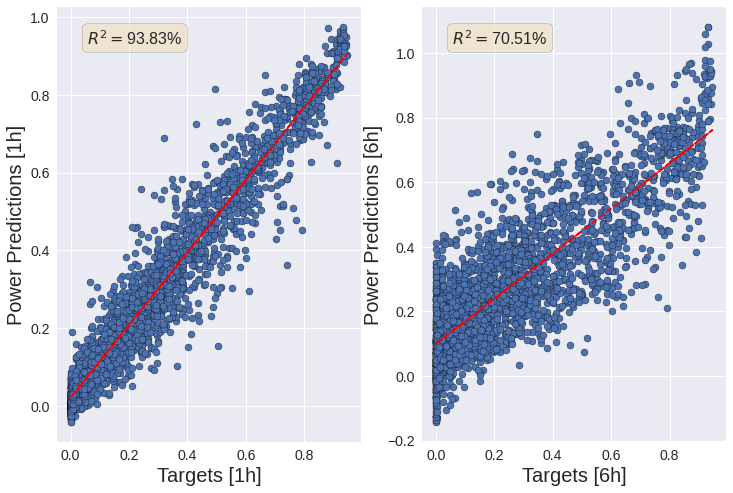

In [141]:
# text box properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
loc=(0.1,0.95)
# begin subplot
fig=plt.figure()
ax=fig.add_subplot(1,2,1)
ax.scatter(p_targets1h , pred_1h ,edgecolors="k") # change
textstr = r'$R^2=$%.2f%s' % (fit1h[2]**2*100,"%")
y=np.reshape(np.array(p_targets1h), (len(p_targets1h,)))
ax.plot(y,y*fit1h[0]+fit1h[1],"r--")
ax.text(loc[0],loc[1], textstr, transform=ax.transAxes,
  fontsize=16, verticalalignment='top', bbox=props)
ax.set_xlabel("Targets [1h]")
ax.set_ylabel("Power Predictions [1h]")

ax=fig.add_subplot(1,2,2)
ax.scatter(p_targets6h , pred_6h ,edgecolors="k") # change
textstr = r'$R^2=$%.2f%s' % (fit6h[2]**2*100,"%")
y=np.reshape(np.array(p_targets6h), (len(p_targets6h,)))
ax.plot(y,y*fit6h[0]+fit6h[1],"r--")
ax.text(loc[0],loc[1], textstr, transform=ax.transAxes,
  fontsize=16, verticalalignment='top', bbox=props)
ax.set_xlabel("Targets [6h]")
ax.set_ylabel("Power Predictions [6h]")
plt.show()
  #NEXT SUPLOT...


In [75]:
import seaborn as sns

In [137]:
residuals6h = np.reshape(np.array(p_targets6h), (len(p_targets6h,)))   -      np.array(pred_6h)
residuals1h = np.reshape(np.array(p_targets1h), (len(p_targets1h,)))   -      np.array(pred_1h)

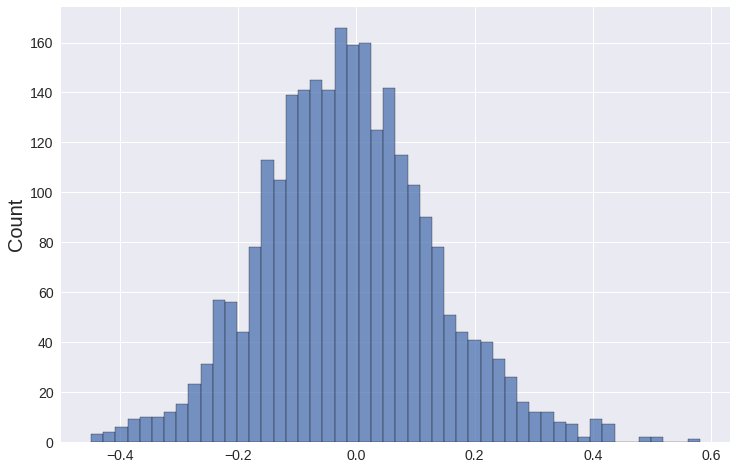

In [136]:
sns.histplot(residuals6h, bins = 50)

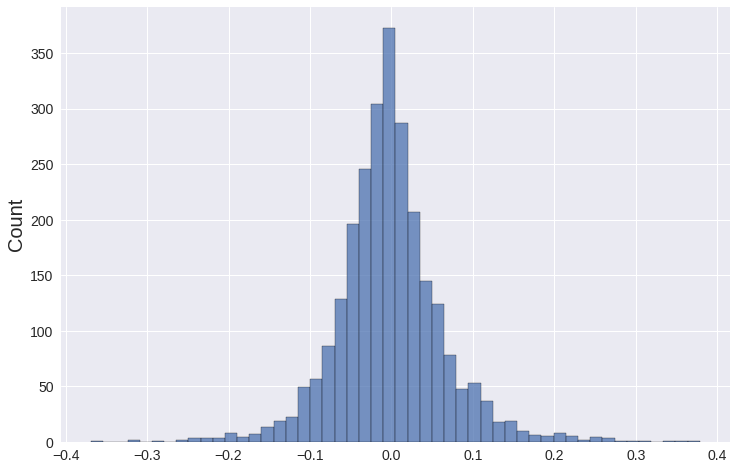

In [138]:
sns.histplot(residuals1h, bins = 50)

In [ ]:
# Estimation of confidence intervals:
RMSE_1h = np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))
RMSE_2h = np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))
RMSE_3h = np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))
CI_1h = [norm.ppf(0.025)*RMSE_1h,norm.ppf(0.975)*RMSE_1h]
CI_2h = [norm.ppf(0.025)*RMSE_2h,norm.ppf(0.975)*RMSE_2h]
CI_3h = [norm.ppf(0.025)*RMSE_3h,norm.ppf(0.975)*RMSE_3h]
print(f'Confidence interval 1h: {CI_1h}')
print(f'Confidence interval 2h: {CI_2h}')
print(f'Confidence interval 3h: {CI_3h}')

Persistent

In [144]:
p_targets1h[0]

array([0.441])

In [154]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []
pred_4h = []
err_4h = []
pred_5h = []
err_5h = []
pred_6h = []
err_6h = []

# Loop over the sequences of valid data
for seq in range(1,len(p_inputs)):  #len(p_inputs)


    # Take output for the past sequence
#    pred_1h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_1h.append(p_targets1h[seq][0]-p_targets1h[seq-1][0])
    # print(f'True value for 1h : {p_targets1h[seq][0]}')
    # print(f'Prediction for 1h : {p_targets1h[seq-1][0]}')

    # Repeat with prediction 2 hours ahead actualizing the past values

    err_2h.append(p_targets2h[seq][0]-p_targets1h[seq-1][0])

    # print(f'True value for 2h : {p_targets2h[seq][0]}')
    # print(f'Prediction for 2h : {p_targets1h[seq-1][0]}')

    # Repeat with prediction 3 hours ahead
    err_3h.append(p_targets3h[seq][0]-p_targets1h[seq-1][0])

    # print(f'True value for 3h : {p_targets3h[seq][0]}')
    # print(f'Prediction for 3h : {p_targets1h[seq-1][0]}')

    # Repeat with prediction 4 hours ahead
    err_4h.append(p_targets4h[seq][0]-p_targets1h[seq-1][0])

    # Repeat with prediction 5 hours ahead

    err_5h.append(p_targets5h[seq][0]-p_targets1h[seq-1][0])

    # Repeat with prediction 6 hours ahead

    err_6h.append(p_targets6h[seq][0]-p_targets1h[seq-1][0])

    if seq % 100 == 0:
      print(f'step {seq+1}, RMSE 1h: {np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))}, RMSE 2h: {np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))}, RMSE 3h: {np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))}, RMSE 4h: {np.sqrt(stat.mean(err_4h[n]**2 for n in range(len(err_4h))))}, RMSE 5h: {np.sqrt(stat.mean(err_5h[n]**2 for n in range(len(err_5h))))}, RMSE 6h: {np.sqrt(stat.mean(err_6h[n]**2 for n in range(len(err_6h))))}')

step 101, RMSE 1h: 0.06697141181130946, RMSE 2h: 0.10843703241974119, RMSE 3h: 0.13398167785186152, RMSE 4h: 0.1523451344808885, RMSE 5h: 0.17001388178616475, RMSE 6h: 0.18952192485303646
step 201, RMSE 1h: 0.07334412041874931, RMSE 2h: 0.11460746049014436, RMSE 3h: 0.14155131578335825, RMSE 4h: 0.15953509018394668, RMSE 5h: 0.17760052083256964, RMSE 6h: 0.19824695457938316
step 301, RMSE 1h: 0.07423388714057752, RMSE 2h: 0.11508039219027136, RMSE 3h: 0.14102906319857147, RMSE 4h: 0.15842365143290107, RMSE 5h: 0.17416905580498507, RMSE 6h: 0.19277720300906953
step 401, RMSE 1h: 0.07174487786594944, RMSE 2h: 0.11205295623052522, RMSE 3h: 0.13895595525201504, RMSE 4h: 0.15815075086764527, RMSE 5h: 0.175336818723279, RMSE 6h: 0.19362730954077734
step 501, RMSE 1h: 0.06903491870061122, RMSE 2h: 0.10720610990050894, RMSE 3h: 0.131987006936289, RMSE 4h: 0.14988418195393402, RMSE 5h: 0.1656451689606431, RMSE 6h: 0.18214427797765156
step 601, RMSE 1h: 0.07404355700081766, RMSE 2h: 0.1140057820

array([0.531])